In [39]:
import pandas as pd
import numpy as np
import mglearn
from mglearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

# 受信者動作特性(Receiver Operating Characteristics Curve: ROC)
さまざまなスレッショルドにおけるクラス分類器の挙動を解析するために良く使われているもう一つの手法。  
ROCカーブは与えられたクラス分類器のすべてのスレッショルドを考慮するが、適合率と再現率のカーブの代わりに、**偽陽性率(false positive rate: FRP)**を**真陽性率(ture positive rate:TPR)**に対してプロットする。真陽性率は再現率の別名だが、偽陽性率はすべての陰性サンプルの個数に対する偽陽性数の数である  
\begin{equation}
FPR = \frac{FP}{FP+TN}
\end{equation}

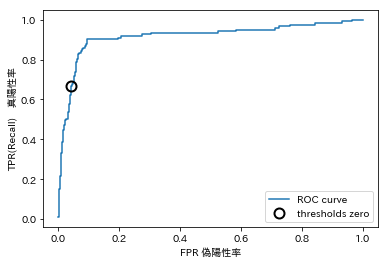

In [13]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2], random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('FPR 偽陽性率')
plt.ylabel('TPR(Recall)　真陽性率')
#0に最も近いスレッショルドを見つける
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='thresholds zero', fillstyle='none', c='k', mew=2)
plt.legend()

理想は左上の領域である。つまり高い真陽性率=Recall=再現率を保ちながら、偽陽性の割合を抑えているような領域だ。今回の場合で言えば、スレッショルドを少し増やすだけで、偽陽性率を抑えながら高い真陽性率(およそ0.9)を達成できる。  
*****
### 図の見方を順を追ってみよう
例えば、ある病気の罹患と血圧の関係を考える。
1. スレッショルドを血圧80以上にして、ある病気に罹患しているとする。血圧80はほとんどの人が当てはまるので真陽性率も高いが偽陽性率も高くなる。図で言えば右上の部分
2. スレッショルドを血圧200以上にして、ある病気に罹患しているとする。正常なひとで血圧200の人はあまりいないので偽陽性率は低くなるが、かといって病気の罹患者で血圧200は高く見積もり過ぎているとすると、真陽性率も低くなる。図で言えば左下の部分。　　

**1.と2.のスレッショルドのトレードオフを図にしたのがROC曲線である。つまり、陽性を正しく陽性と言えるかを端的に表した図であると言える。**

ランダムフォレストと比べてみよう。

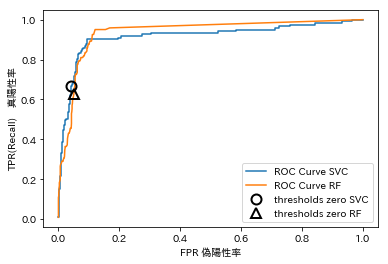

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='ROC Curve SVC')
plt.plot(fpr_rf, tpr_rf, label='ROC Curve RF')

plt.xlabel('FPR 偽陽性率')
plt.ylabel('TPR(Recall)　真陽性率')
#0に最も近いスレッショルドを見つける
close_zero = np.argmin(np.abs(thresholds))
close_zero_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='thresholds zero SVC', fillstyle='none', c='k', mew=2)
plt.plot(fpr_rf[close_zero_rf], tpr_rf[close_zero_rf], '^', markersize=10, label='thresholds zero RF', fillstyle='none', c='k', mew=2)
plt.legend()

適合率-再現率カーブと同様にカーブの下の領域面積をもってROCカーブを一つの値として評価することができる(カーブのしたの領域(area under the curve)を略して一般にAUCと呼ぶ)。ROCカーブの下の領域をroc_auc_score関数で計算することができる。

In [18]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print('AUC for random forest: {:.3f}'.format(rf_auc))
print('AUC for SVC: {:.3f}'.format(svc_auc))

AUC for random forest: 0.937
AUC for SVC: 0.916


ランダムフォレストとSVMをAUCスコアで比較すると、ランダムフォレストの方がSVMよりも少しだけ良いことがわかる(AUCスコア0(最悪値)~1(最良値))。ランダムに予測するようなクラス分類器に対してはどんなにクラスが**偏ったデータセットであってもAUCは常に0.5になる。したがって偏ったクラス分類問題を評価する際の基準としては精度よりもAUCの方がはるかによい指標である。**  
- AUCは陽性サンプルの予測のランキングを評価していると解釈される(参考:https://takuti.me/note/auc/)
> このときAUCは『予測スコアでサンプルを（降順）ソートしたときに、True Positive となるサンプルが False Positive となるサンプルより上位にきているか』ということを測る。つまり、ラベル 1 のサンプルに正しく高スコアを与える予測器であるか を見ている。

digitsデータセットで「9」と「9以外」(「9」が「9以外に」比べて圧倒的にすくない)をクラス分類する問題を見てみよう

gamma = 1.00 accurancy = 0.90 AUC = 0.50
gamma = 0.15 accurancy = 0.90 AUC = 0.79
gamma = 0.01 accurancy = 0.90 AUC = 1.00


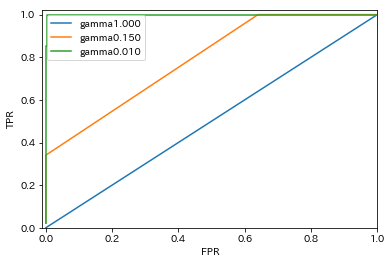

In [37]:
from sklearn.datasets import load_digits
digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0) 

plt.figure()

for gamma in [1, 0.15, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accurancy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print('gamma = {:.2f} accurancy = {:.2f} AUC = {:.2f}'.format(gamma, accurancy, auc))
    
    plt.plot(fpr, tpr, label='gamma{:.3f}'.format(gamma))
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc='best')

どのgammaに対しても精度は90%である。これチャンスレベルの性能(=ランダムに選択した場合でも偶然の一致で得られた性能)かもしれないし、そうではないかもしれない。  
しかしAUCと対応するカーブをみると3つのモデルの違いがはっきりとわかる。gamma=1の場合ではAUCは0.5となり、ランダムに選択した場合と同一の性能しかない。gamma0.15ではAUCが大きく改善し0.79である。gamma=0.01でAUC＝1となり、**これは(ランキング的に考えると)全ての陽性データポイントがすべての陰性データポイントよりも決定関数で良いスコアを得ているということだ。  つまり適切にスレッショルドを設定すれば(陽性と陰性の境目)このモデルはデータを完全に分離できるということになる。**

# 多クラス分類の基準
2クラス分類と同様に多クラス分類における精度は正確に分類されたクラスの割合である。これはやはり偏ったデータセットにおいては評価基準として適切ではない。  
例えば85%がクラスA、10%がクラスB、5%がクラスCに属する3クラス分類を考えてみる。精度が85%と得られた場合これはなにを意味するだろうか？

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print('Accurancy {:.3f}'.format(accuracy_score(y_test, pred)))
print('Confusion matrix: \n{}'.format(confusion_matrix(y_test, pred)))

Accurancy 0.953
Confusion matrix: 
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


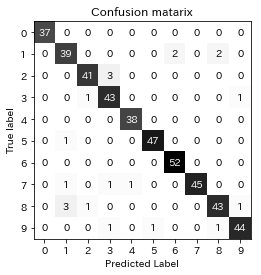

In [42]:
socre_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), 
                                    xlabel='Predicted Label', ylabel='True label', xticklabels=digits.target_names,
                                    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt='%d'
                                   )

plt.title('Confusion matarix')
plt.gca().invert_yaxis()

数字0については37個サンプルがあり、行方向で見てみるとエントリがすべて0なので、偽陰性(tureは0なのにpredictは0でない他の数字)がないことがわかる。列方向にみるとエントリがすべて0なので偽陽性(tureは0でないのに、predictが0)もないことがわかる。
他の数字は例えば1について、6と判定される偽陰性が2つ存在していることがわかる。

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



クラス0は適合率も再現率も1なので完璧に分類できていることがわかる。一方クラス7は適合率は1、つまり偽陽性がないが、再現率は0.94で偽陰性が存在していることがわかる。逆にクラス6については再現率が1なので偽陰性がないことがわかる。このレポートをみると1と8と3の分類を苦手としていることがわかる。  
偏ったデータセットにおける多クラス分類における最もよく使われる基準は多クラス版のf-値である。多クラス板野f-値は、まずここのクラスに対して、陽性クラス、他を陰性クラスとしてf-値を算出して、次にクラスごとのf値を次のようにして平均する。

- 'macro'平均：重みをつけずにクラスごとのf-値を平均する。クラスのサイズを考慮せずにすべてに同じ重みをつける。
- 'weighted'平均:各クラスのサイズに応じて重みをつけてクラスごとのf-値を平均する。classification_reportで算出されるf-値。
- 'micro'平均：すべてのクラスの偽陽性、偽陰性、真陽性の総数を計算してその値を用いて適合率、再現率、f-値を計算する。